<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/Super_Resolution/SRCNN(2014).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference
- https://github.com/kawaiimaths/pytorch_srcnn
- https://github.com/fuyongXu/SRCNN_Pytorch_1.0
- https://debuggercafe.com/image-super-resolution-using-deep-learning-and-pytorch/

In [1]:
from google.colab import drive
drive.mount('srcnn')

Mounted at srcnn


In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
import srcnn
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터셋 불러오기
- 아래 홈페이지에서 데이터셋을 다운로드 받습니다.
- https://drive.google.com/file/d/1aPxBtvIEMWrLt-awM-0Fko8sJONqOpUx/view

In [4]:
# 디렉토리 이동
!cd /content

In [5]:
# 데이터를 저장할 폴더 생성
!mkdir data

In [ ]:
# 압축 풀기
!unzip /content/srcnn/MyDrive/data/input.zip -d /content/data

In [7]:
# 입력 이미지 차원 설정하기
input_h, input_w = 33, 33 # sub-image에 대한 크기
out_h, out_w = 33, 33 # label인 high-resolution에 대한 크기

In [50]:
# sub-images와 label 읽어오기
file = h5py.File('/content/data/train_mscale.h5')
in_train = file['data'][:] # train data
out_train = file['label'][:] # train label
file.close()

# float32로 타입 변경
in_train = in_train.astype('float32')
out_train = out_train.astype('float32')

In [51]:
# 0.75: 0.15 = train : val 분할
(x_train, x_val, y_train, y_val) = train_test_split(in_train, out_train, test_size=0.25)
print(x_train.shape[0])
print(x_val.shape[0])

16368
5456


In [52]:
# 커스텀 데이터셋 생성하기
class SRCNNDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels

    def __len__(self):
        return (len(self.image_data))

    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float))

In [53]:
# 데이터셋 생성
train_ds = SRCNNDataset(x_train, y_train)
val_ds = SRCNNDataset(x_val, y_val)

# 데이터로더 생성
train_dl = DataLoader(train_ds, batch_size=64)
val_dl = DataLoader(val_ds, batch_size=64)

In [54]:
# 데이터 체크
for x, y in train_dl:
    print(x.shape, y.shape)
    break

torch.Size([64, 1, 33, 33]) torch.Size([64, 1, 33, 33])


In [55]:
# 데이터 시각화
img = x[0]
target = y[0]
print(img.shape, target.shape)
print(img.dtype)

torch.Size([1, 33, 33]) torch.Size([1, 33, 33])
torch.float32


Text(0.5, 1.0, 'target')

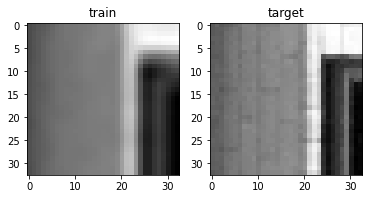

In [56]:
from torchvision.transforms.functional import to_pil_image

plt.figure()
plt.subplot(1,2,1)
plt.imshow(to_pil_image(img), cmap='gray')
plt.title('train')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(target), cmap='gray')
plt.title('target')

# 모델 구축하기

In [57]:
class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # padding_mode='replicate'는 zero padding이 아닌, 주변 값을 복사해서 padding 합니다.
        self.conv1 = nn.Conv2d(1, 64, 9, padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv2d(64, 32, 1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 1, 5, padding=2, padding_mode='replicate')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        return x

In [58]:
# check
x = torch.randn(64,1,33,33).to(device)
model = SRCNN().to(device)
output = model(x)
print(output.shape)

torch.Size([64, 1, 33, 33])


In [59]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

model.apply(initialize_weights);

# 학습하기

In [60]:
# 손실함수
loss_func = nn.MSELoss()

# optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

In [61]:
# PSNR function: 모델의 출력값과 high-resoultion의 유사도를 측정합니다.
# PSNR 값이 클수록 좋습니다.
def psnr(label, outputs, max_val=1.):
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff)**2))
    if rmse == 0: # label과 output이 완전히 일치하는 경우
        return 100
    else:
        psnr = 20 * math.log10(max_val/rmse)
        return psnr

In [62]:
# train 함수
def train(model, data_dl):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0

    for ba, data in enumerate(data_dl):
        image = data[0].to(device)
        label = data[1].to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = loss_func(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_psnr = psnr(label, outputs)
        running_psnr += batch_psnr
    
    final_loss = running_loss / len(data_dl.dataset)
    final_psnr = running_psnr / int(len(train_ds)/data_dl.batch_size)
    return final_loss, final_psnr

In [63]:
# validation 함수
def validate(model, data_dl, epoch):
    # epoch는 이미지를 저장할때, 이미지의 이름으로 사용됩니다.
    
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for ba, data in enumerate(data_dl):
            image = data[0].to(device)
            label = data[1].to(device)

            outputs = model(image)
            loss = loss_func(outputs, label)

            running_loss += loss.item()
            batch_psnr = psnr(label,outputs)
            running_psnr += batch_psnr

        outputs = outputs.cpu()
        # tensor를 입력받아 이미지 파일로 저장합니다.
        save_image(outputs, f'/content/outputs/{epoch}.png')
    
    final_loss = running_loss / len(data_dl.dataset)
    final_psnr = running_psnr / int(len(val_ds)/data_dl.batch_size)
    return final_loss, final_psnr

In [64]:
# 이미지를 저장할 폴더 생성
!mkdir outputs

mkdir: cannot create directory ‘outputs’: File exists


In [65]:
num_epochs = 100

# 학습하기
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} of {num_epochs}')
    train_epoch_loss, train_epoch_psnr = train(model, train_dl)
    val_epoch_loss, val_epoch_psnr = validate(model, val_dl, epoch)

    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
    end = time.time()
    print(f'Train PSNR: {train_epoch_psnr:.3f}, Val PSNR: {val_epoch_psnr:.3f}, Time: {end-start:.2f} sec')

Epoch 1 of 100
Train PSNR: 22.478, Val PSNR: 25.961, Time: 2.06 sec
Epoch 2 of 100
Train PSNR: 25.978, Val PSNR: 26.507, Time: 4.09 sec
Epoch 3 of 100
Train PSNR: 26.541, Val PSNR: 27.037, Time: 6.12 sec
Epoch 4 of 100
Train PSNR: 26.920, Val PSNR: 27.279, Time: 8.15 sec
Epoch 5 of 100
Train PSNR: 27.080, Val PSNR: 27.380, Time: 10.20 sec
Epoch 6 of 100
Train PSNR: 27.140, Val PSNR: 27.414, Time: 12.23 sec
Epoch 7 of 100
Train PSNR: 27.160, Val PSNR: 27.404, Time: 14.26 sec
Epoch 8 of 100
Train PSNR: 27.178, Val PSNR: 27.448, Time: 16.28 sec
Epoch 9 of 100
Train PSNR: 27.194, Val PSNR: 27.465, Time: 18.31 sec
Epoch 10 of 100
Train PSNR: 27.201, Val PSNR: 27.475, Time: 20.34 sec
Epoch 11 of 100
Train PSNR: 27.211, Val PSNR: 27.478, Time: 22.39 sec
Epoch 12 of 100
Train PSNR: 27.218, Val PSNR: 27.478, Time: 24.43 sec
Epoch 13 of 100
Train PSNR: 27.225, Val PSNR: 27.490, Time: 26.46 sec
Epoch 14 of 100
Train PSNR: 27.234, Val PSNR: 27.504, Time: 28.50 sec
Epoch 15 of 100
Train PSNR: 27.24

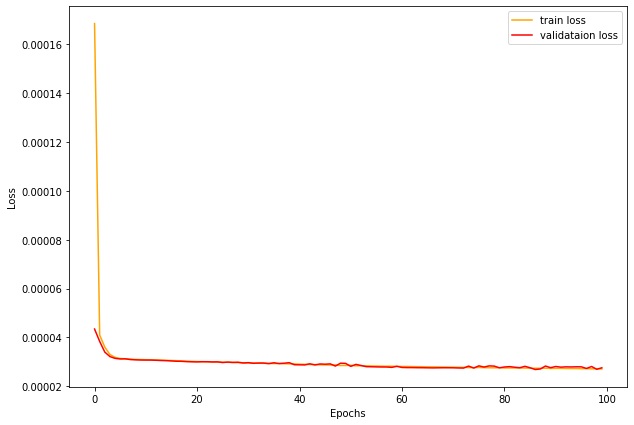

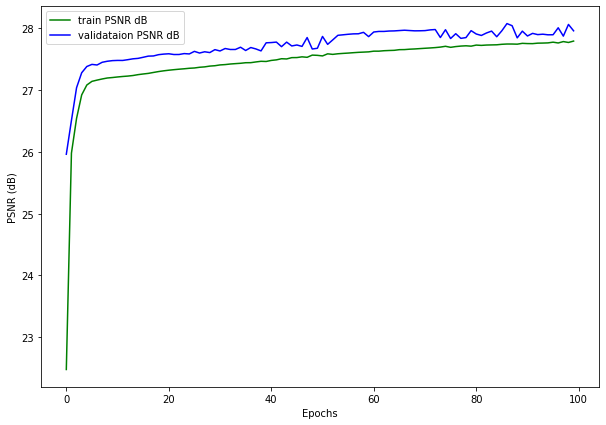

In [66]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()

# Test

Text(0.5, 1.0, 'ground_truth')

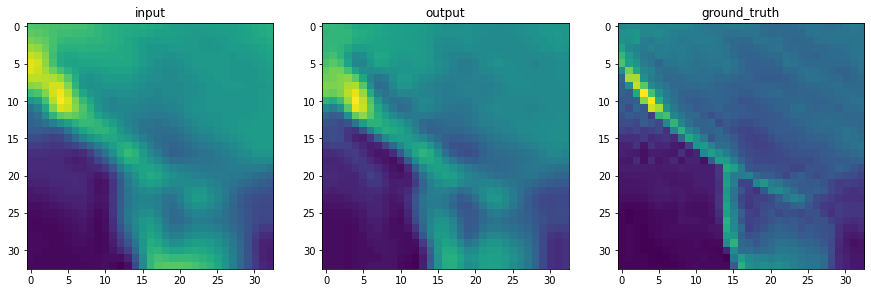

In [80]:
# 이미지 꺼내기
for img, label in val_dl:
    img = img[0]
    label = label[0]
    break

# super-resolution
model.eval()
with torch.no_grad():
    img_ = img.unsqueeze(0)
    img_ = img_.to(device)
    output = model(img_)
    output = output.squeeze(0)

# 시각화
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(to_pil_image(img))
plt.title('input')
plt.subplot(1,3,2)
plt.imshow(to_pil_image(output))
plt.title('output')
plt.subplot(1,3,3)
plt.imshow(to_pil_image(label))
plt.title('ground_truth')